In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from src import models, data
from tqdm.auto import tqdm
import json

In [15]:
device = "cuda:0"
mt = models.load_model("gptj", device=device)
print(
    f"dtype: {mt.model.dtype}, device: {mt.model.device}, memory: {mt.model.get_memory_footprint()}"
)

dtype: torch.float16, device: cuda:0, memory: 12219206136


In [16]:
mt.__dict__.keys()

dict_keys(['model', 'tokenizer', 'vocab_size', 'n_layer', 'n_embd', 'n_attn_head', 'max_seq_length', 'layer_name_format', 'layer_names', 'mlp_module_name_format', 'attn_module_name_format', 'ln_f_name', 'unembedder_name', 'embedder_name', 'model_type'])

In [17]:
prompt = "The Space Needle is located in the city of"
tokenized = mt.tokenizer(prompt, return_tensors="pt", padding=True).to(mt.model.device)

In [18]:
import baukit

with baukit.TraceDict(
    mt.model,
    mt.layer_names,
) as traces:
    output = mt.model(**tokenized)

In [19]:
output.logits[0][-1].shape

torch.Size([50400])

In [73]:
def untuple(x):
    if isinstance(x, tuple):
        return x[0]
    return x


def interpret_logits(mt, logits, top_k=10, get_proba = False):
    logits = torch.nn.functional.softmax(logits, dim=-1) if get_proba else logits
    token_ids = logits.topk(dim=-1, k=top_k).indices.squeeze().tolist()
    logit_values = logits.topk(dim=-1, k=top_k).values.squeeze().tolist()
    return [
        (mt.tokenizer.decode(t), round(v, 3)) for t, v in zip(token_ids, logit_values)
    ]


def logit_lens(
    mt,
    h,
    interested_tokens=[],
    get_proba=False,
):
    logits = mt.lm_head(h)
    logits = torch.nn.functional.softmax(logits, dim=-1) if get_proba else logits
    candidates = interpret_logits(mt, logits)
    interested_logits = {
        t.item(): (logits[t].item(), mt.tokenizer.decode(t)) for t in interested_tokens
    }
    return candidates, interested_logits


# interpret_logits(mt, output.logits[0][-1])

In [21]:
# interested_words = [" Seattle", " Paris", " Dhaka"]
# int_tokenized = mt.tokenizer(interested_words, return_tensors="pt", padding=True).to(
#     mt.model.device
# )
# int_tokenized.input_ids

# z = untuple(traces[mt.layer_names[-1]].output)[0][-1]
# print(z.shape)

# logit_lens(mt, z, [t[0] for t in int_tokenized.input_ids], get_proba=False)

In [22]:
def filter_by_model_knowledge(mt, relation_prompt, relation_samples):
    model_knows = []
    for sample in relation_samples:
        tokenized = relation_prompt.format(sample.subject)
        output = mt.model(
            **mt.tokenizer(tokenized, return_tensors="pt", padding=True).to(
                mt.model.device
            )
        )

        object_id = output.logits[0][-1].argmax().item()
        object = mt.tokenizer.decode(object_id)

        tick = sample.object.strip().startswith(object.strip())
        # print(object, sample.object, tick)

        if tick:
            model_knows.append(sample)

    return model_knows

In [24]:
dataset = data.load_dataset()
capital_cities = dataset[0]
capital_cities.__dict__.keys()

dict_keys(['name', 'prompt_templates', 'samples', '_domain', '_range'])

In [25]:
import numpy as np

icl_indices = np.random.choice(range(len(capital_cities.samples)), 3, replace=False)
icl_samples = [capital_cities.samples[i] for i in icl_indices]
icl_prompt = [
    f"{capital_cities.prompt_templates[0].format(sample.subject)} {sample.object}"
    for sample in icl_samples
]
icl_prompt = "\n".join(icl_prompt) + "\n" + capital_cities.prompt_templates[0]

print(icl_prompt)

The capital city of India is New Delhi
The capital city of Germany is Berlin
The capital city of Turkey is Ankara
The capital city of {} is


In [26]:
model_knows = filter_by_model_knowledge(mt, icl_prompt, capital_cities.samples)
len(model_knows)

23

## Layer Richness based on logit lens

In [ ]:
def layer_richness(mt, relation_prompt, subject, verbose=False):
    tokenized = relation_prompt.format(subject)
    with baukit.TraceDict(mt.model, layers=mt.layer_names) as traces:
        output = mt.model(
            **mt.tokenizer(tokenized, return_tensors="pt", padding=True).to(
                mt.model.device
            )
        )

    object_id = output.logits[0][-1].argmax().item()
    object = mt.tokenizer.decode(object_id)
    # base_logit = output.logits[0][-1][object_id].item()
    base_score = torch.nn.functional.softmax(output.logits[0][-1], dim=-1)[
        object_id
    ].item()

    if verbose:
        print(f"object ==> {object} [{object_id}], base = {base_score}")

    layer_contributions = {}

    prev_score = 0
    for layer in mt.layer_names:
        h = untuple(traces[layer].output)[0][-1]
        candidates, interested_logits = logit_lens(
            mt, h, torch.tensor([object_id]), get_proba=True
        )
        layer_score = interested_logits[object_id][0]
        cur_layer_contribution = (layer_score - base_score) / base_score

        layer_contributions[layer] = cur_layer_contribution

        if verbose:
            print(f"layer: {layer}, diff: {cur_layer_contribution}")

        prev_score = layer_score

    return layer_contributions


relation_prompt = mt.tokenizer.eos_token + " {} is located in the city of"
subject = "The Space Needle"
layer_richness(mt, relation_prompt, subject, verbose=True)

In [ ]:
layer_richness_info = {layer: [] for layer in mt.layer_names}

for sample in tqdm(model_knows):
    cur_richness = layer_richness(mt, icl_prompt, sample.subject)
    for layer in mt.layer_names:
        layer_richness_info[layer].append(cur_richness[layer])

# with open("layer_sweep/layer_contribution_info.json", "w") as f:
with open("layer_sweep/layer_completeness_info.json", "w") as f:
    json.dump(layer_richness_info, f)

for layer in mt.layer_names:
    layer_richness_info[layer] = np.array(layer_richness_info[layer])

In [ ]:
mean_richness = [layer_richness_info[layer].mean() for layer in mt.layer_names]
low_richness = [layer_richness_info[layer].min() for layer in mt.layer_names]
high_richness = [layer_richness_info[layer].max() for layer in mt.layer_names]

plt.plot(mean_richness, color="blue")
plt.fill_between(range(len(mean_richness)), low_richness, high_richness, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("completeness")
plt.xticks(range(0, len(mean_richness), 2))

plt.show()

## Layer Richness based on `Jh_norm` and `J_norm`

In [ ]:
import copy

capital_cities_known = copy.deepcopy(capital_cities.__dict__)
capital_cities_known["samples"] = model_knows

capital_cities_known = data.Relation(**capital_cities_known)

In [ ]:
from src.data import RelationSample
RelationSample(subject="Russia", object="Moscow")

In [ ]:
print(icl_prompt)

In [ ]:
from src.operators import JacobianEstimator, JacobianIclMeanEstimator

# mean_estimator = JacobianIclMeanEstimator(
#     mt=mt,
#     h_layer=12,
# )

# operator = mean_estimator(capital_cities_subset)
# operator("Russia", k = 10).predictions

In [ ]:
estimator = JacobianEstimator(
    mt=mt,
    h_layer=12,
)

operator = estimator.call_on_sample(
    sample = RelationSample(subject="Russia", object="Moscow"),
    prompt_template= icl_prompt
)

In [ ]:
operator.misc["Jh"].norm()

In [ ]:
relation_prompt = icl_prompt
subject = "Russia"
layer_richness(mt, relation_prompt, subject, verbose=True)

In [ ]:
layerwise_jh = {layer: [] for layer in mt.layer_names}

for sample in tqdm(set(model_knows) - set(icl_samples)):
    for h_layer in range(0, 24):
        layer_name = mt.layer_name_format.format(h_layer)
        estimator = JacobianEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = estimator.call_on_sample(
            # sample = RelationSample(subject="Russia", object="Moscow"),
            sample = sample,
            prompt_template= icl_prompt
        )

        # print(h_layer, " ===> ", f"J:{operator.weight.norm().item()},  Jh: {operator.misc['Jh'].norm().item()}")
        layerwise_jh[layer_name].append({
            "J": operator.weight.norm().item(),
            "Jh": operator.misc['Jh'].norm().item(),
            "bias": operator.bias.norm().item()
        })

In [ ]:
for layer in mt.layer_names:
    if layer in layerwise_jh and len(layerwise_jh[layer]) == 0:
        layerwise_jh.pop(layer)

with open("layer_sweep/layer_jh_info.json", "w") as f:
    json.dump(layerwise_jh, f)

In [ ]:
key = "Jh"

info = {
    layer: np.array([layerwise_jh[layer][i][key] for i in range(len(layerwise_jh[layer]))])
    for layer in layerwise_jh.keys()
}

mean = [info[layer].mean() for layer in info.keys()]
plt.plot(mean, color="blue", linewidth=4)
plt.xticks(range(0, len(mean), 2))
plt.ylabel(f"{key}_norm")

for i in range(len(set(model_knows) - set(icl_samples))):
    arr = []
    for layer in layerwise_jh.keys():
        arr.append(layerwise_jh[layer][i][key])
    plt.plot(arr, alpha=0.2)

plt.show()

## Causal Tracing on `subject_last`

In [50]:
from src.operators import _compute_h_index

# h_idx, inputs = _compute_h_index(
#     mt = mt, 
#     prompt = "The location of {} is in the city of".format(subject_original),
#     subject = subject_original,
#     offset=-1
# )

# print(h_idx, inputs)
# for t in inputs.input_ids[0]:
#     print(t.item(), mt.tokenizer.decode(t.item()))

In [75]:
subject_original = "The Space Needle"
subject_corruption = "Eiffel Tower"

prompt_template = "{} is located in the city of"

with baukit.TraceDict(
    mt.model, mt.layer_names
) as traces_o:
    output_o = mt.model(**mt.tokenizer(prompt_template.format(subject_original), return_tensors="pt").to(device))

answer, p_answer = interpret_logits(mt, output_o.logits[0][-1], get_proba=True)[0]
answer, p_answer

(' Seattle', 0.986)

In [76]:
with baukit.TraceDict(
    mt.model, mt.layer_names
) as traces_c:
    output_c = mt.model(**mt.tokenizer(prompt_template.format(subject_corruption), return_tensors="pt").to(device))

interpret_logits(mt, output_c.logits[0][-1], get_proba=True)

[(' Paris', 0.835),
 (' Champ', 0.035),
 ('\n', 0.01),
 (' the', 0.01),
 (' love', 0.008),
 (' La', 0.007),
 (' Stras', 0.007),
 (' Gren', 0.004),
 (' Tours', 0.004),
 (' France', 0.004)]

In [77]:
h_idx_orig, _ = _compute_h_index(
    mt = mt,
    prompt = prompt_template.format(subject_original),
    subject = subject_original,
    offset=-1
) 

h_idx_corr, _ = _compute_h_index(
    mt = mt,
    prompt = prompt_template.format(subject_corruption),
    subject = subject_corruption,
    offset=-1
)

h_idx_orig, h_idx_corr

(3, 3)

In [78]:
untuple(traces_o[mt.layer_name_format.format(20)].output).shape

torch.Size([1, 10, 4096])

In [86]:
answer_t = mt.tokenizer(answer, return_tensors="pt").to(device).input_ids[0]
answer_t

tensor([7312], device='cuda:0')

In [91]:
def get_replace_intervention(intervention_layer, intervention_tok_idx, h_intervention):
    def intervention(output, layer):
        if(layer != intervention_layer):
            return output
        output[0][0][intervention_tok_idx] = h_intervention
        return output
    return intervention


for layer_idx in range(mt.n_layer):
    intervention_layer = mt.layer_name_format.format(layer_idx)

    with baukit.TraceDict(
        mt.model, 
        layers = mt.layer_names,
        edit_output = get_replace_intervention(
            intervention_layer= intervention_layer,
            intervention_tok_idx= h_idx_corr,
            h_intervention = untuple(traces_o[intervention_layer].output)[0][h_idx_orig]
        )
    ) as traces_i:
        output_i = mt.model(**mt.tokenizer(prompt_template.format(subject_corruption), return_tensors="pt").to(device))

    z = untuple(traces_i[mt.layer_names[-1]].output)[0][-1]
    candidates, interested = logit_lens(mt, z, [answer_t], get_proba=True)
    layer_p = interested[answer_t.item()][0]

    print(intervention_layer, layer_p)

transformer.h.0 0.003498077392578125
transformer.h.1 0.0095672607421875
transformer.h.2 0.9462890625
transformer.h.3 0.95849609375
transformer.h.4 0.96826171875
transformer.h.5 0.97509765625
transformer.h.6 0.97314453125
transformer.h.7 0.9755859375
transformer.h.8 0.97314453125
transformer.h.9 0.966796875
transformer.h.10 0.95703125
transformer.h.11 0.9580078125
transformer.h.12 0.9365234375
transformer.h.13 0.8896484375
transformer.h.14 0.89892578125
transformer.h.15 0.892578125
transformer.h.16 0.21435546875
transformer.h.17 0.212646484375
transformer.h.18 0.2236328125
transformer.h.19 0.0005092620849609375
transformer.h.20 4.291534423828125e-06
transformer.h.21 2.1457672119140625e-06
transformer.h.22 2.205371856689453e-06
transformer.h.23 2.3245811462402344e-06
transformer.h.24 2.384185791015625e-06
transformer.h.25 2.4437904357910156e-06
transformer.h.26 2.2649765014648438e-06
transformer.h.27 2.2649765014648438e-06


In [97]:
def causal_tracing(
    mt,
    prompt_template,
    subject_original, subject_corruption,
    verbose = False
): 
    h_idx_orig, tokenized_orig = _compute_h_index(
        mt = mt,
        prompt = prompt_template.format(subject_original),
        subject = subject_original,
        offset=-1
    ) 

    h_idx_corr, tokenized_corr = _compute_h_index(
        mt = mt,
        prompt = prompt_template.format(subject_corruption),
        subject = subject_corruption,
        offset=-1
    )

    with baukit.TraceDict(
        mt.model, mt.layer_names
    ) as traces_o:
        output_o = mt.model(**tokenized_orig)

    answer, p_answer = interpret_logits(mt, output_o.logits[0][-1], get_proba=True)[0]
    answer_t = mt.tokenizer(answer, return_tensors="pt").to(device).input_ids[0]

    if(verbose):
        print(f"answer: {answer}[{answer_t.item()}], p(answer): {p_answer:.3f}")

    result = {}
    for intervention_layer in mt.layer_names:
        with baukit.TraceDict(
            mt.model, 
            layers = mt.layer_names,
            edit_output = get_replace_intervention(
                intervention_layer= intervention_layer,
                intervention_tok_idx= h_idx_corr,
                h_intervention = untuple(traces_o[intervention_layer].output)[0][h_idx_orig]
            )
        ) as traces_i:
            output_i = mt.model(**mt.tokenizer(prompt_template.format(subject_corruption), return_tensors="pt").to(device))

        z = untuple(traces_i[mt.layer_names[-1]].output)[0][-1]
        candidates, interested = logit_lens(mt, z, [answer_t], get_proba=True)
        layer_p = interested[answer_t.item()][0]

        if(verbose):
            print(intervention_layer, layer_p)
        result[intervention_layer] = (layer_p - p_answer)/p_answer
    
    return result


causal_tracing(
    mt,
    prompt_template = "The location of {} is in the city of",
    subject_original = "Eiffel Tower",
    subject_corruption = "The Space Needle",
    verbose = True
)

answer:  Paris[6342], p(answer): 0.879
transformer.h.0 0.003604888916015625
transformer.h.1 0.06378173828125
transformer.h.2 0.85498046875
transformer.h.3 0.849609375
transformer.h.4 0.8095703125
transformer.h.5 0.84765625
transformer.h.6 0.8505859375
transformer.h.7 0.818359375
transformer.h.8 0.81494140625
transformer.h.9 0.78955078125
transformer.h.10 0.81103515625
transformer.h.11 0.80126953125
transformer.h.12 0.8017578125
transformer.h.13 0.76171875
transformer.h.14 0.73291015625
transformer.h.15 0.57080078125
transformer.h.16 0.0107269287109375
transformer.h.17 0.006511688232421875
transformer.h.18 0.0043182373046875
transformer.h.19 1.2576580047607422e-05
transformer.h.20 3.0994415283203125e-06
transformer.h.21 3.337860107421875e-06
transformer.h.22 3.3974647521972656e-06
transformer.h.23 3.3974647521972656e-06
transformer.h.24 6.377696990966797e-06
transformer.h.25 6.377696990966797e-06
transformer.h.26 6.318092346191406e-06
transformer.h.27 6.198883056640625e-06


{'transformer.h.0': -0.9958988749533383,
 'transformer.h.1': -0.9274382954707053,
 'transformer.h.2': -0.027325974118316273,
 'transformer.h.3': -0.03343643344709898,
 'transformer.h.4': -0.07898713026166099,
 'transformer.h.5': -0.035658418657565416,
 'transformer.h.6': -0.03232544084186576,
 'transformer.h.7': -0.068988196814562,
 'transformer.h.8': -0.07287667093287828,
 'transformer.h.9': -0.10176247866894199,
 'transformer.h.10': -0.07732064135381116,
 'transformer.h.11': -0.08843056740614334,
 'transformer.h.12': -0.08787507110352674,
 'transformer.h.13': -0.13342576791808874,
 'transformer.h.14': -0.16620004977246872,
 'transformer.h.15': -0.3506248222411832,
 'transformer.h.16': -0.9877964406018913,
 'transformer.h.17': -0.9925919360268238,
 'transformer.h.18': -0.9950873295737344,
 'transformer.h.19': -0.9999856921728696,
 'transformer.h.20': -0.9999964739004228,
 'transformer.h.21': -0.9999962026619938,
 'transformer.h.22': -0.9999961348523866,
 'transformer.h.23': -0.9999961

In [98]:
import copy

capital_cities_known = copy.deepcopy(capital_cities.__dict__)
capital_cities_known["samples"] = model_knows

capital_cities_known = data.Relation(**capital_cities_known)

In [99]:
num_icl = 3

icl_indices = np.random.choice(range(len(capital_cities_known.samples)), num_icl, replace=False)
icl_samples = [capital_cities.samples[i] for i in icl_indices]
icl_prompt = [
    f"{capital_cities.prompt_templates[0].format(sample.subject)} {sample.object}"
    for sample in icl_samples
]
icl_prompt = "\n".join(icl_prompt) + "\n" + capital_cities.prompt_templates[0]

print(icl_prompt)

The capital city of Chile is Santiago
The capital city of Italy is Rome
The capital city of Mexico is Mexico City
The capital city of {} is


In [118]:
test_samples = set(capital_cities_known.samples) - set(icl_samples)
causal_tracing_results = {layer: [] for layer in mt.layer_names}

n_runs = 20
for run in tqdm(range(n_runs)):
    sample_pair = np.random.choice(range(len(test_samples)), 2, replace=False)
    sample_pair = [list(test_samples)[i] for i in sample_pair]
    print(sample_pair)
    
    cur_result = causal_tracing(
        mt,
        prompt_template = icl_prompt,
        subject_original = sample_pair[0].subject,
        subject_corruption = sample_pair[1].subject,
        verbose = False
    )

    for layer in mt.layer_names:
        causal_tracing_results[layer].append(cur_result[layer])

  0%|          | 0/20 [00:00<?, ?it/s]

[RelationSample(subject='Nigeria', object='Abuja'), RelationSample(subject='Colombia', object='Bogot\\u00e1')]
[RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='Venezuela', object='Caracas')]
[RelationSample(subject='Germany', object='Berlin'), RelationSample(subject='Japan', object='Tokyo')]
[RelationSample(subject='France', object='Paris'), RelationSample(subject='India', object='New Delhi')]
[RelationSample(subject='Egypt', object='Cairo'), RelationSample(subject='Brazil', object='Bras\\u00edlia')]
[RelationSample(subject='Pakistan', object='Islamabad'), RelationSample(subject='Saudi Arabia', object='Riyadh')]
[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='South Korea', object='Seoul')]
[RelationSample(subject='Japan', object='Tokyo'), RelationSample(subject='United States', object='Washington D.C.')]
[RelationSample(subject='France', object='Paris'), RelationSample(subject='Saudi Arabia', object='Riyadh')]
[Rela

In [119]:
with open("layer_sweep/causal_tracing_results.json", "w") as f:
    json.dump(causal_tracing_results, f)

for layer in mt.layer_names:
    causal_tracing_results[layer] = np.array(causal_tracing_results[layer])

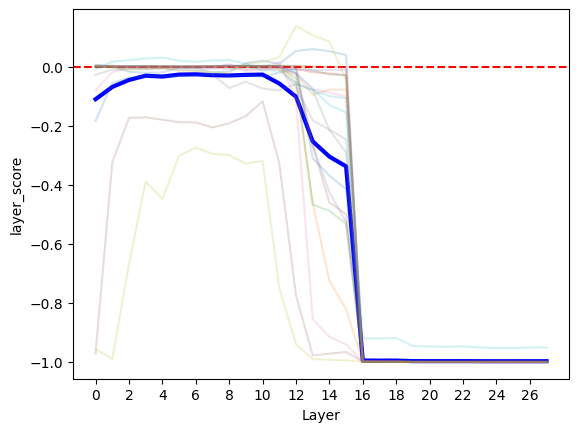

In [121]:
mean = [causal_tracing_results[layer].mean() for layer in mt.layer_names]
# low = [causal_tracing_results[layer].min() for layer in mt.layer_names]
# high = [causal_tracing_results[layer].max() for layer in mt.layer_names]

plt.plot(mean, color="blue", linewidth=3)
# plt.fill_between(range(len(mean)), low, high, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("layer_score")
plt.xticks(range(0, mt.n_layer, 2))

for run in range(n_runs):
    arr = []
    for layer in mt.layer_names:
        arr.append(causal_tracing_results[layer][run])
    plt.plot(arr, alpha=0.2)


plt.show()

## Layer sweep on mean ICL

In [ ]:
import copy

capital_cities_known = copy.deepcopy(capital_cities.__dict__)
capital_cities_known["samples"] = model_knows

capital_cities_known = data.Relation(**capital_cities_known)

In [ ]:
indices = np.random.choice(range(len(capital_cities_known.samples)), 2, replace=False)
samples = [capital_cities_known.samples[i] for i in indices]

capital_cities_subset = copy.deepcopy(capital_cities.__dict__)
capital_cities_subset["samples"] = samples
capital_cities_subset = data.Relation(**capital_cities_subset)

len(capital_cities_subset.samples)

In [ ]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
)

operator = mean_estimator(capital_cities_subset)

In [ ]:
operator("Chile", k = 10).predictions

In [ ]:
predictions = []
target = []

for sample in tqdm(set(capital_cities_known.samples)):
    cur_predictions = operator(sample.subject, k = 5).predictions
    predictions.append([
        p.token for p in cur_predictions
    ])
    target.append(sample.object)

In [ ]:
from src.metrics import recall

recall(predictions, target)

In [ ]:
# np.savez("layer_sweep/operator_weight.npz", jacobian = operator.weight.detach().cpu().numpy(), allow_pickle=True)

In [ ]:
# j = np.load("layer_sweep/operator_weight.npz", allow_pickle=True)["jacobian"]

In [ ]:
# torch.dist(torch.tensor(j).to(device), operator.weight)

In [ ]:
def get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True):

    layer_wise_recall = {}

    for h_layer in tqdm(range(0, 24)):
        layer_name = mt.layer_name_format.format(h_layer)
        mean_estimator = JacobianIclMeanEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = mean_estimator(capital_cities_subset)
        if(save_weights):
            np.savez(
                f"layer_sweep/weights_and_biases/{layer_name}.npz", 
                jacobian = operator.weight.detach().cpu().numpy(),
                bias = operator.bias.detach().cpu().numpy(), 
                allow_pickle=True
            )

        predictions = []
        target = []

        for sample in set(capital_cities_known.samples) - set(capital_cities_subset.samples):
            cur_predictions = operator(sample.subject, k = 5).predictions
            predictions.append([
                p.token for p in cur_predictions
            ])
            target.append(sample.object)

        layer_wise_recall[layer_name] = recall(predictions, target)
        
        if(verbose):
            print(layer_name, layer_wise_recall[layer_name])
    
    return layer_wise_recall

layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True)

In [ ]:
with open("layer_sweep/layer_wise_recall.json", "w") as f:
    json.dump(layer_wise_recall, f)

In [ ]:
layer_wise_recall_collection = {}
number_of_runs = 10

for run in tqdm(range(number_of_runs)):
    indices = np.random.choice(range(len(capital_cities_known.samples)), 2, replace=False)
    samples = [capital_cities_known.samples[i] for i in indices]

    capital_cities_subset = copy.deepcopy(capital_cities.__dict__)
    capital_cities_subset["samples"] = samples
    capital_cities_subset = data.Relation(**capital_cities_subset)

    layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose=False, save_weights=False)

    for layer in layer_wise_recall.keys():
        if(layer not in layer_wise_recall_collection):
            layer_wise_recall_collection[layer] = []
        layer_wise_recall_collection[layer].append(layer_wise_recall[layer])

In [ ]:
with open("layer_sweep/layer_wise_recall_collection.json", "w") as f:
    json.dump(layer_wise_recall_collection, f)

In [ ]:
top_1 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 0]
    for layer in layer_wise_recall_collection.keys()
])
top_1.mean(axis = 1)

In [ ]:
# top_1 = [layer_wise_recall[layer][0] for layer in layer_wise_recall.keys()]
# top_2 = [layer_wise_recall[layer][1] for layer in layer_wise_recall.keys()]
# top_3 = [layer_wise_recall[layer][2] for layer in layer_wise_recall.keys()]

top_1 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 0]
    for layer in layer_wise_recall_collection.keys()
])

top_2 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 1]
    for layer in layer_wise_recall_collection.keys()
])

top_3 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 2]
    for layer in layer_wise_recall_collection.keys()
])




plt.plot(top_1.mean(axis=1), color="green", linewidth=3, label="recall@1")
plt.plot(top_2.mean(axis=1), color="blue", linewidth=2, label="recall@2")
plt.plot(top_3.mean(axis=1), color="red", linewidth=1, label="recall@3")

plt.fill_between(
    range(len(layer_wise_recall_collection.keys())),
    top_1.min(axis=1), top_1.max(axis=1),
    color="green", alpha=0.1
)

plt.xticks(range(0, len(top_1), 2))
plt.xlabel("layer")
plt.ylabel("recall")

plt.legend()
plt.show()

In [ ]:
from src.utils.misc import visualize_matrix

for h_layer in range(0, 24):
    layer_name = mt.layer_name_format.format(h_layer)
    j = np.load(f"layer_sweep/weights_and_biases/{layer_name}.npz", allow_pickle=True)["jacobian"]
    j = torch.tensor(j).to(device)
    print(layer_name, j.shape)
    visualize_matrix(j, title = layer_name, save_path=f"layer_sweep/Jacobian_plots/{layer_name}.png")